In [2]:
using HDF5
function VariablesBRWChole( FILEBRW )
    BRW = h5open( FILEBRW, "r" );

    Variables = Dict(
    "Description" => read( open_attribute( BRW, "Description" ) ),
    "ExperimentDateTimeUtc" => read( open_attribute( BRW, "ExperimentDateTimeUtc" ) ),
    "ExperimentType" => read( open_attribute( BRW, "ExperimentType" ) ),
    "GUID" => read( open_attribute( BRW, "GUID" ) ),
    "MaxAnalogValue" => read( open_attribute( BRW, "MaxAnalogValue" ) ),
    "MaxDigitalValue" => read( open_attribute( BRW, "MaxDigitalValue" ) ),
    "MinAnalogValue" => read( open_attribute( BRW, "MinAnalogValue" ) ),
    "MinDigitalValue" => read( open_attribute( BRW, "MinDigitalValue" ) ),
    "PlateModel" => read( open_attribute( BRW, "PlateModel" ) ),
    "SamplingRate" => read( open_attribute( BRW, "SamplingRate" ) ),
    "Version" => read( open_attribute( BRW, "Version" ) ),
    "ExperimentSettings" => read_dataset( BRW, "ExperimentSettings" ),
    "ImageLayers" => read_dataset( BRW, "ImageLayers" ),
    "TOC" => read_dataset( BRW, "TOC" ),
    "brwfile" => h5open( FILEBRW, "r" ).filename;
    );
    Well_A1 = read( open_group(  BRW, "Well_A1" ) );
    Variables = merge( Variables, Well_A1 );
    
    return Variables
    
end


# -------------------------------------------------------------------------------------------------------- #
using HDF5
using JLD
using DelimitedFiles
"""
VariablesBRW( FILEBRW::String ) -> Variables::Dict{ String, Any }, FILEPATHS::String
    Reads the version of BRW and if it is the latest ( 102 ) version, extract a dictionary with the variables of interest
    It also creates an Info folder where it saves a .jld file with that dictionary for future uses.

    Notes: falta considerar las versiones viejas de brw, esto funciona para 2020 ->
"""
function VariablesBRW( FILEBRW::String )

    BRW = h5open( FILEBRW, "r" );
    Description = read( open_attribute( BRW, "Description" ) );
    BRWversion = []
    try
        BRWversion = read_attribute( open_group( BRW, "3BData" ), "Version" );
    catch e
        BRWversion = read( open_attribute( BRW, "Version" ) );
    end
    BRWsize = ( ( stat( FILEBRW ).size ) / 1000000 ) / 1024;
    PATHBRWs = dirname( FILEBRW );
    if BRWversion == 102
        aux = split( Description, "," )[ end - 1 : end ];
        day = split( aux[ 1 ] )[ 2 ];
        month = split( aux[ 1 ] )[ 1 ][ 1 : 3 ];
        year = split( aux[ end ] )[ 1 ];
        brw = replace( splitpath( FILEBRW )[ end ], ".brw" => "" );
        PATHMain = joinpath( dirname( PATHBRWs ), string( brw, "-", day, "-", month, "-", year ) );
        mkpath( PATHMain );
        RecVars = read( open_group(  BRW, "3BRecInfo" ), "3BRecVars" );

        for i in keys( RecVars )
            RecVars[ i ] = RecVars[ i ][ 1 ];
        end

        MeaChip = read( open_group(  BRW, "3BRecInfo" ), "3BMeaChip" );
        delete!( MeaChip, "ROIs" ); delete!( MeaChip, "SysChs" );

        for i in keys( MeaChip )
            MeaChip[ i ] = MeaChip[ i ][ 1 ];
        end

        for i in keys( MeaChip )
            MeaChip[ i ] = convert( Int, MeaChip[ i ] );
        end

        MeaChip[ "Layout" ] = reshape( collect( 1:MeaChip[ "NRows" ] * MeaChip[ "NCols" ] ), MeaChip[ "NRows" ], MeaChip[ "NCols" ] );
        Noise = read( open_group( open_group(  BRW, "3BData" ), "3BInfo"), "3BNoise" );
        RawPath = Dict( "Raw" => "3BData/Raw" ); filename = h5open( FILEBRW, "r" ).filename;
        Description = Dict( "Description" => Description, "Version" => BRWversion, "BRW" => filename );
        RecVars[ "BitDepth" ] = convert( Int, RecVars[ "BitDepth" ] );
        SignalInversion = RecVars[ "SignalInversion" ];
        MaxVolt = RecVars[ "MaxVolt" ]; MinVolt = RecVars[ "MinVolt" ]; BitDepth = RecVars[ "BitDepth" ];
        ADCCountsToMV = SignalInversion * ( ( MaxVolt - MinVolt )/ 2^BitDepth );
        MVOffset = SignalInversion * MinVolt;
        Extras = Dict( "MVOffset" => MVOffset, "ADCCountsToMV" => ADCCountsToMV, "BRWsizeGB" => BRWsize );
        Variables = merge( Description, RecVars, MeaChip, Noise, RawPath, Extras );

        for i in keys( Variables )
            try
                Variables[ i ] = convert( Int, Variables[ i ] );
            catch
                Variables[ i ] = Variables[ i ];
            end
        end

        PATHInfo = joinpath( PATHMain, "Info" ); mkpath( PATHInfo );
        FILEVARS = joinpath( PATHInfo, "variablesBRW.jld");
        save( FILEVARS, "Variables", Variables );

        close( BRW )
        cd( PATHMain )

        println( "You are now working on the new main path: ", PATHMain );
        println( "with the file: ", basename( BRW.filename ) );
        println( Description[ "Description" ] );
        println( "HDF5 file size: $BRWsize GB" );

        TEXTVars = copy( Variables );
        delete!( TEXTVars, "StdMean" ); delete!( TEXTVars, "ValidChs" ); delete!( TEXTVars, "Layout" );
        FILEVARS = joinpath( PATHInfo, "variablesBRW.txt");
        writedlm( FILEVARS, TEXTVars );
        FILEPATHS = joinpath( PATHInfo, "Paths.jld" );
        PATHS = Dict(
            "PATHMain" => PATHMain,
            "PATHInfo" => PATHInfo,
            "PATHBRWs" => PATHBRWs
            )
        save( FILEPATHS, "PATHS", PATHS )
    else
        println( "You need another function for the: ", BRWversion, " version files, please consult the BRW manual" );
        Variables = Dict( );
        FILEPATHS = "";
    end

    return Variables, FILEPATHS

end

# -------------------------------------------------------------------------------------------------------- #
"""
    EST( bin::Array, thr::Real, parametros::Dict{String, Int64} )
        Se obtienen los frames y voltajes que sobrepasan el umbral establecido (thr)
        Si hay eventos supraumbral a n frames de distancia, (stokes) se selecciona aquel que
        tenga menor voltaje.
        Depende del paquete StatsBase

    """
function EST( bin::Array, thr::Real, parametros::Dict{String, Int64} )
    stokes = parametros[ "stokes" ];
    ST = findall( bin .<= thr ); # eventos que pasan el umbral
    if !isempty( ST )
        init = 1;
        while init == 1
            separacion = ST[ 2:end ] .- ST[ 1:( end - 1 ) ]; # distancia entre ellos
            cercanos = findall( separacion .<= stokes ) .+ 1; # cuales estan cerca
            if isempty( cercanos )
                init = 0;
            else
                eliminar = zeros( Int, size( cercanos, 1 ) );
                for i = 1:size( cercanos, 1 )
                    # si el primero es menor que el segundo, quita el segundo
                    if isless( ( bin[ ST[ cercanos[ i ] ] ] ),
                            ( bin[ ST[ cercanos[ i ] - 1 ] ] ) )
                        eliminar[ i ] = cercanos[ i ] - 1;
                    else
                        eliminar[ i ] = cercanos[ i ];
                    end
                end
                if size( eliminar, 1 ) > 1
                    ST[ unique( eliminar ) ] .= 0;
                    filter!( x -> x != 0, ST );
                else
                    ST = ST[ Bool.( ST .!= ST[ eliminar[ 1 ] ] ) ];
                end
            end
        end
        index_parcial = zeros( size( ST, 1 ), 1 );
        index_parcial[ :, 1 ] = ST;
    else
        index_parcial = [ ];
    end
    return index_parcial
end

using Statistics
"""
    EventosXCanal( canal::Array, parametros::Dict{String, Int64} )
        Identifica el numero de eventos en una ventana temporal que se desplaza
        Stokes es la distancia minima entre eventos para ser considerados uno solo
        Depende de la funcion EST, BRW y el paquete Statistics
"""
function EventosXCanal( canal::Array, parametros::Dict{String, Int64} )
    index = [ ];
    window = parametros[ "window" ]; displace = parametros[ "displace" ]; stdmin = parametros[ "stdmin" ];
    i = 1
    Inicio = Int( ( ( ( i - 1 ) * displace ) + 1 ) ); Final = Int( Inicio + window - 1 );
    thrs = 0;
    while Final <= ( length( canal ) - Int( window - 1 ) )
        bin =  canal[ Inicio:Final ];
        if !iszero( bin )
            thr = -1 * stdmin * ( median( abs.( bin ) ) / 0.6745 );
            thrs = vcat( thrs, thr );
            index_parcial = Int.( EST( bin, thr, parametros ) );
            if !isempty( index_parcial )
                index_real = index_parcial .+ Inicio .- 1;
                index = vcat( index, index_real );
            end
        end
        i = i + 1;
        Inicio = Int( ( ( ( i - 1 ) * displace ) + 1 ) ); Final = Int( Inicio + window - 1 );
    end
    thrs = thrs[ 2:end ]; index = unique( index );
    return index, thrs
end
"""
    div_ab( n::Int64, lo::Int = 1, hi::Int = n )
        Divisors of the number n between the values "lo" and "hi", if they are not defined then it takes from 1 to n
"""
function div_ab( n::Int, lo::Int = 1, hi::Int = n )
    ρ = collect( 1:floor( Int, sqrt( n ) ) ) ; # the numbers one by one, from the square root
    σ1 = findall( n.%ρ .== 0 ); # square root divisors ( remainder = 0 )
    σ2 = Int.( ( n ) ./ ( σ1 ) ); # Take out the pairs (of 100, 2-50, 10-10, etc.)
    σ = sort( unique( vcat( σ1, σ2 ) ) ); # remove duplicates, concatenate, sort
    aux1 = @isdefined lo;
    aux2 = @isdefined hi;
    if aux1 && aux2
        rn = σ[ findall( hi .>= σ .>= lo ) ];
        if isempty( rn )
            println(" there is no divisors of $n between $lo and $hi" )
        else
            return rn
        end
    else
        return σ
    end
end
function ms2frames( time::Real, SamplingRate::Real )
    if time != 0
        x = ceil( Int, ( time * SamplingRate ) / 1000 );
    else
        x = 1
    end
    return x
end
using Statistics
function ΔV( Variables::Dict{String, Any}, BIN::Matrix{Float64}, ΔT::Int64 )

    SamplingRate = Variables[ "SamplingRate" ][ 1 ];
    ΔT = ms2frames( ΔT, SamplingRate );

    STD = vec( std( ( BIN - circshift( BIN, ( 0, ΔT )  ) ), dims = 2 ) );

    return STD

end
using DSP
"""
"""
function FiltroMUAremez( Variables::Dict{String, Any}, canal::Vector{Float64} )

    SamplingRate = Variables[ "SamplingRate" ];
    lF = 300; fac = 10; HF = 3000;
    NYQ = floor( Int, SamplingRate / 2 );
    order = Int( floor( ( SamplingRate / lF ) / 5 ) );

    bpass = remez(
        ( order + 1 ), [ ( 0, lF - fac ) => 0, ( lF, HF ) => 1, ( HF + fac, NYQ ) => 0 ],
            Hz = SamplingRate );
    MUA = filtfilt( DSP.Filters.PolynomialRatio( bpass, [ 1.0 ] ), canal );
    return MUA
end
using Statistics
"""
    Noise-adaptive Optimal Thresholding
        donoho( x::Vector ) -> thr::Float64
"""
@inline donoho( x ) =  ( median( abs.( x ) ) / 0.6745 );

"""
"""
function Z0( X, nChs )

    Z = zeros( Int, nChs );
    Z[ X ] = Z[ X ] .+ 1;
    Z = reverse( reshape( Z, Int(sqrt( nChs )), Int(sqrt( nChs )) )', dims = 1 );

    return Z
end

# -------------------------------------------------------------------------------------------------------- #
"""
"""
function ZW( X, nChs )
    Z = reverse( reshape( X, Int(sqrt( nChs )), Int(sqrt( nChs )) )', dims = 1 );
    return Z
end

# -------------------------------------------------------------------------------------------------------- #
"""
"""
function Zplot( Z, which, nChs, cm = :greys )
    if which == "0"
        Z = Z0( Z, nChs );
    elseif which == "W"
        Z = ZW( Z, nChs );
    end
    F = heatmap(
            Z,
            aspect_ratio = 1,
            c = cm,
            axis = ( [ ], false ),
            wsize = ( 400, 400 ),
            #cbar = :none
        );
    return F

end

Zplot

In [3]:
FILEBRW = "/run/media/isabel/Data/Hipocampo/Espontanea/01-06-2022/BRWs/Phase_12.brw"
Variables, FILEPATHS = VariablesBRW( FILEBRW );
MVOffset = Variables[ "MVOffset" ]; ADCCountsToMV = Variables[ "ADCCountsToMV" ];

You are now working on the new main path: /run/media/isabel/Data/Hipocampo/Espontanea/01-06-2022/Phase_12-1-Jun-2022
with the file: Phase_12.brw
BRW-File Level3 - 3Brain RaW data file for high resolution MEA platform, HDF5-format - Created with BrainWave v.4.5.8180.23837 on date Wednesday, June 1, 2022
HDF5 file size: 0.28579403515625 GB


In [7]:
FILEBRW = "/home/isabel/Desktop/Misc/Data/Files_Chole/example2.brw"; cd(dirname( FILEBRW ));
Variables = VariablesBRWChole( FILEBRW );

In [8]:
DigitalValue = Variables[ "Raw" ];
AnalogValue = MVOffset .+ ( DigitalValue .* ADCCountsToMV );

nChs = Int( length( Variables[ "Raw" ] ) / maximum( Variables[ "TOC" ] ) );
NRecFrames = Int( length( Variables[ "Raw" ] ) / nChs );
channels = collect( 1:nChs );

data = Array{ Float64 }( undef, nChs, NRecFrames ); # preallocate

for i = 1:nChs
    index = collect(i:nChs:Int( length( Variables[ "Raw" ] ) ));
    data[ i, : ] = AnalogValue[ index ];
end

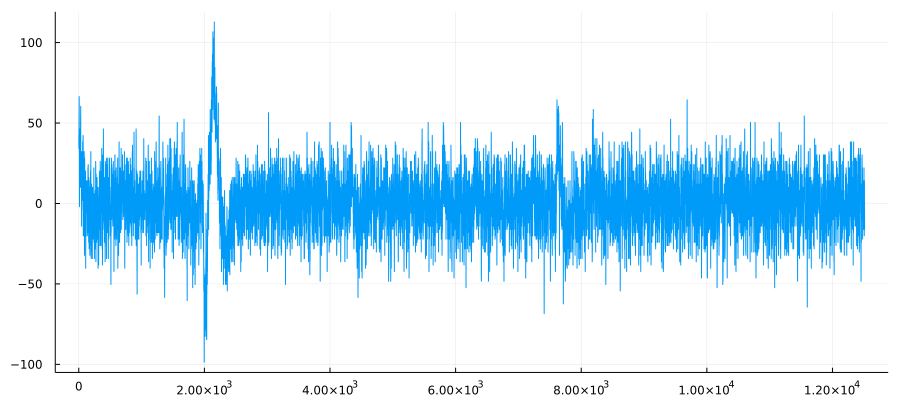

In [36]:
using Plots
plot( data[ 100, : ], leg = :none, wsize = ( 900, 400 ) )

In [20]:
data, earth, MinVoltSatChannels = SaturacionPositiva( Variables, data );

there is something fishy here


In [24]:
nChs = length( Variables[ "StoredChIdxs" ] );
SamplingRate = Variables[ "SamplingRate" ];
MinVolt = Float64( Variables[ "MinAnalogValue" ] + 1 );
channels = collect( 1:nChs );
binsize = size( data, 2 );
MinVoltSat = sum( Int.( data .== MinVolt ), dims = 2 );

In [28]:
SatFramesLimit = ceil( Int, SamplingRate*0.005 );
        NineNinePercent = ceil( Int, binsize*0.99 );
        MinVoltSatChannels = findall( vec( NineNinePercent .>= MinVoltSat .>= SatFramesLimit ) );
        aux = findall( vec( MinVoltSat ) .>= NineNinePercent );

-237.6708984375

In [19]:
function SaturacionPositiva( Variables::Dict{String, Any}, data )

    nChs = length( Variables[ "StoredChIdxs" ] );
    SamplingRate = Variables[ "SamplingRate" ];
    MinVolt = Float64( Variables[ "MinAnalogValue" ] + 1 );
    channels = collect( 1:nChs );
    binsize = size( data, 2 );
    MinVoltSat = sum( Int.( data .== MinVolt ), dims = 2 );

    if length( findall( vec( MinVoltSat ) .== 0 ) ) == ( nChs - 1 )
        earth = setdiff( channels, findall( vec( MinVoltSat ) .== 0 ) )[ ];
        MinVoltSatChannels = [ ];
        data[ earth, : ] .= 0;
    else
        SatFramesLimit = ceil( Int, SamplingRate*0.005 );
        NineNinePercent = ceil( Int, binsize*0.99 );
        MinVoltSatChannels = findall( vec( NineNinePercent .>= MinVoltSat .>= SatFramesLimit ) );
        aux = findall( vec( MinVoltSat ) .>= NineNinePercent );
        if length( aux ) == 1
            earth = aux[ 1 ];
            data[ earth, : ] .= 0;
        else
            println( "there is something fishy here" );
            earth = []
        end
    end
    return data, earth, MinVoltSatChannels
end

SaturacionPositiva (generic function with 1 method)

In [ ]:
VO = zeros( Float64, nChs ); # preallocation
[ VO[ k ] = length( unique( data[ k, : ] ) ) for k in channels ];

In [ ]:
SamplingRate = Variables["SamplingRate"];

In [ ]:
DeltaV = ΔV( Variables, data, 250 );

In [ ]:
W = std( data, dims = 2 );

In [ ]:
F1 = Zplot( VO, "W", nChs, :bluesreds );
F2 = Zplot( log.( DeltaV ), "W", nChs, :bluesreds );
#F3 = Zplot( log.( eventos ), "W", nChs, :bluesreds );
F4 = Zplot( log.(W), "W", nChs, :bluesreds );
plot(F1,F2,F3,F4, layout = (2,2), wsize=(700,700))

In [ ]:
# Para hacer los filtrados y deteccion de espigas
window = 5; # ms tamaño de la ventana
displace = 1; # ms desplazamiento de la ventana
stokes = 0.3; # ms distancia mínima entre evento y evento detectado
stdmin = 3; # umbral de deteccion
w_pre = 1; # ms
w_post = 2; # ms

# Centrando las espigas
Icut = 0.5; # ms cuantos puntos
Lcut = 1; # ms

parametros = Dict(
"window" => ms2frames( window, SamplingRate ),
        "displace" => ms2frames( displace, SamplingRate ),
        "stokes" => ms2frames( stokes, SamplingRate ),
        "w_pre" => ms2frames( w_pre, SamplingRate ),
        "w_post" => ms2frames( w_post, SamplingRate ),
        "Icut" => ms2frames( Icut, SamplingRate ),
        "Lcut" => ms2frames( Lcut, SamplingRate ),
        "stdmin" => stdmin
);

eventos_filt = [ ];
eventos_raw = [ ];
for i = 1:nChs
    raw = data[ i, : ];
    filt = FiltroMUAremez( Variables, raw );
    index_filt, _ = EventosXCanal( filt, parametros );
    index_raw, _ = EventosXCanal( raw, parametros );
    push!( eventos_filt, index_filt )
    push!( eventos_raw, index_raw)
end

In [ ]:
W1 = length.(eventos_raw);
W2 = length.(eventos_filt);

In [ ]:
X1 = Zplot( W1, "W", nChs, :bluesreds );
X2 = Zplot( W2, "W", nChs, :bluesreds );

In [ ]:
plot(X1,X2, wsize=(900,400))

In [ ]:
nobin = zeros( Int, size( data ) );

In [ ]:
for i = 1:length( eventos_filt )
    nobin[ i, eventos_filt[ i ] ] = nobin[ i, eventos_filt[ i ] ] .+ 1;
end

In [ ]:
size( data,2 )/2/2/2/2/2

In [ ]:
seg = 391;
i = 1
j = i + seg - 1
scatter( nobin[ :, i:j ] )

In [ ]:
DocTestSetup = quote
    using Luxor, Colors, ColorSchemes
end

# use a `drawschemes(cschemes)`` function to insert drawings of schemes
# use SVG for Documenter.jl >= 0.27

using Luxor, Colors, ColorSchemes

function draw_a_scheme(pos,cscheme, swatchwidth, swatchheight, counter)
    cols = colorschemes[cscheme].colors
    setline(0.25)
    @layer begin
        translate(pos)

        # text
        fontsize(10)
        fontface("JuliaMono-Regular")
        sethue("white")
        setline(0.1)

        # first position, scheme name
        text(string(cscheme), Point(0, swatchheight/2 + (isodd(counter) ? -5 : 0)), halign=:center)

        # # second position, boxes of colors
        @layer begin
            ncols = length(cols)
            sectorangle = 2π/ncols
            for (n, θ) in enumerate(range(0, 2π, step=sectorangle))
                sethue(cols[mod1(n, end)])
                sector(O, 10, max(swatchwidth, swatchheight)/3, 3π/2 + θ, 3π/2 + θ + sectorangle, :fill)
            end
        end
    end
end

function drawgallery(category;
        filetype=:svg)
    schemes = filter(s -> occursin(category, colorschemes[s].category), collect(keys(colorschemes)))
    # is vector of symbol
    l = length(schemes)
    swatchsize = 80
    ncols = 10
    nrows = 1 + round(l ÷ ncols, RoundUp)
    d = Drawing(800, 50 + (swatchsize * nrows), filetype)
    origin()
    background("grey15")
    sethue("white")
    fontsize(10)
    fontface("JuliaMono-Bold")
    text("Category: " * category, boxtopleft(BoundingBox() + (10, 25)), halign=:left)
    tiles = Partition(800, swatchsize * nrows, swatchsize, swatchsize)
    for (pos, n) in tiles
        draw_a_scheme(pos, schemes[n], tiles.tilewidth, tiles.tileheight, n)
        if n >= l
            break
        end
    end
    finish()
    return d
end

In [ ]:


t0 = 2;
window2 = ms2frames( t0, SamplingRate )

sam = unique(sort(Int.(round.(rand( 15 ).*100))));

binarizacion = zeros( Int, nChs, 21);
for i = 1:length(eventos)
    temporal = ceil.(Int,eventos[1]./Int(NRecFrames/21));
    for j = 1:length(temporal)
        binarizacion[i,temporal[j]] = binarizacion[i,temporal[j]] + 1;
    end
end

i = 1
P = true
W = []
while P == true && i <= size( binarizacion, 2 )
    W = binarizacion[:,i]
    if isempty( findall( W .!= 0 ) )
        P = true
        i = i + 1
    else
        P = false
    end
end

W = findall(W .!= 0);

canal = data[2,:];
I = findall(canal .<= -donoho( canal )*4);

P1 = plot(data[2,:],leg = :none, wsize = ( 900, 400 ));

datafilt = FiltroMUAremez(Variables,data[2,:]);
plot(datafilt,leg = :none, wsize = ( 900, 400 ))
hline!( [-donoho(datafilt)*3])
scatter!( eventos[2], datafilt[eventos[2]])

stokes = parametros[ "stokes" ];
init = 1;
while init == 1
    separacion = index[ 2:end ] .- index[ 1:( end - 1 ) ]; # distancia entre ellos
    cercanos = findall( separacion .<= stokes ) .+ 1; # cuales estan cerca
    if isempty( cercanos )
        init = 0;
    else
        eliminar = zeros( Int, size( cercanos, 1 ) );
        for i = 1:size( cercanos, 1 )
            # si el primero es menor que el segundo, quita el segundo
            if isless( ( MUA[ index[ cercanos[ i ] ] ] ),
                    ( MUA[ index[ cercanos[ i ] - 1 ] ] ) )
                eliminar[ i ] = cercanos[ i ] - 1;
            else
                eliminar[ i ] = cercanos[ i ];
            end
        end
        if size( eliminar, 1 ) > 1
            index[ unique( eliminar ) ] .= 0;
            filter!( x -> x != 0, index );
        else
            index = index[ Bool.( index .!= index[ eliminar[ 1 ] ] ) ];

        end
    end
end
index_final = zeros( size( index, 1 ), 1 ); index_final[ :, 1 ] = index;
index_final = vec( Int.( index_final ) )





X = Variables["StoredChIdxs"];
Z = reverse( reshape( X, Int(sqrt( nChs )), Int(sqrt( nChs )) )', dims = 1 );

ExperimentSettings = Variables["ExperimentSettings"][1];

# ExperimentSettings = replace( ExperimentSettings, "{" => "" );
# ExperimentSettings = replace( ExperimentSettings, "}" => "" );

TEXT = split( ExperimentSettings, "\r\n" );

x = []
#myregex = r"^\s*(?:,#|$)}" 
for i = 1:length(TEXT)
    if !isempty(collect(eachmatch(r"[0-9]", TEXT[i])))
    #if !isempty(collect(eachmatch(r"[a-z]", TEXT[i])))
        push!(x, true)
    else
        push!(x, false)
    end
        
end

TEXT = TEXT[Bool.(x)];

TEXT

TEXT = replace.(TEXT, " " => "");

TEXT[1][1]

TEXT = replace.(TEXT, '"' => "")

writedlm( "text01.txt", TEXT );